In [3]:
# 训练参数设定

eta = 0.001  # 学习率
gamma = 0.9  # 折扣因子
capacity = 50  # 记忆体容量
batch_size = 32  # 批次大小

# 1 数据处理

将数据分通道使用连续小波变换cwt进行处理，处理成每个类别的8通道数据

## 处理过程

读取文件，获得数据，整理数据格式

设定计算必要的参数，分通道计算连续小波变换

得到小波计算结果

In [1]:
# 分通道小波变换
import numpy as np
import pandas as pd
import pywt


def trans(csv_file):
    """
    读取CSV文件，并应用连续小波变换
    :param csv_file: 读取CSV文件的路径
    :return:
    """
    # 数据获取
    df = pd.read_csv(csv_file)  # 读取CSV文件
    signal = df.iloc[:, :]  # 获取指定列的数据
    length, channels = signal.shape  # 获取行数和列数
    
    # 假设采样频率为fs
    fs = 1024  # 采样频率
    dt = 1 / fs  # 采样间隔
    widths = np.arange(1, 235)  # 定义尺度范围
    
    # 时频图像尺度数据
    x = np.linspace(0, length * dt, length)
    
    # 初始化数据存储数组
    coefficients = np.zeros((channels, len(widths), length))  # 小波变换系数
    frequencies = np.zeros(len(widths))  # 小波变换频率

    # 对每个频道进行小波变换
    for i in range(0, channels):
        signal_transed = signal.iloc[:, i]
        print(f"开始频道{i}的变换")
        coefficients[i, :, :], frequencies = pywt.cwt(signal_transed, widths, 'morl', dt)  # 使用morlet小波进行连续小波变换
        print(f"完成频道{i}的变换")

    return x, coefficients.astype(np.float32), frequencies

# 数据文件列表

files_20_0 = ['./data/gearset/Chipped_20_0.csv', './data/gearset/Health_20_0.csv', './data/gearset/Miss_20_0.csv', './data/gearset/Root_20_0.csv', './data/gearset/Surface_20_0.csv']

files_30_2 = ['./data/gearset/Chipped_30_2.csv', './data/gearset/Health_30_2.csv', './data/gearset/Miss_30_2.csv', './data/gearset/Root_30_2.csv', './data/gearset/Surface_30_2.csv']

# 处理开始
files = files_30_2

print("处理开始")

for file in files:
    print(file, "文件处理开始")
    
    x_0, coe_0, freq_0 = trans(file)
    
    save_path = file.replace('data', 'dataset').replace('.csv', '.npy')
    np.save(save_path, coe_0)
    
    print(file, "文件处理完成")


ModuleNotFoundError: No module named 'pywt'

# 2 尝试建立DQN模型

## 2’ 说明

### 训练方案

不采用有环境模型方式，改用读取数据+采样方式，通过采样来提供新的学习样本。

状态：数据取样的一个批次

动作：对于状态对应标签的判断（25种动作，包括改变和不改变）

### 数据结构方案

**小波变换得到的数据**：shape为(99, 1048559, 8)，三个维度分别是频率，时间，通道数。

将数据按时间分割成(99, 99, 8)的10591个数据，丢弃最后的50个数据，由此作为DQN的输入数据。

然后将数据整理为批次大小的整数倍，丢弃多余的部分，以适应训练需求

### 包含的技术点

- 离线强化学习：利用静态数据进行强化学习而不是动态学习。
- 批量更新：利用大小为32的批次进行学习。
- 经验回放或优先级经验回放：尝试使用经验回放进行Off-Policy学习，或者替换为优先级经验回放来得到较好的结果。
- 固定Q目标
- 模型蒸馏
- 正则化、Dropout减少过拟合
- 避免数据增强

### 代码架构和构建原理

1.数据处理部分：编写一个数据处理函数，用来自动化将数据整理为所需的方格形式

2.数据加载部分：将上面一个部分处理好的数据文件加载出来，进行分批并处理成所需的格式

3.DQN模型建立部分：分块用面向对象方式建立DQN模型

In [5]:
# 包引用

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import random

## 2.1 数据处理

编写一个数据处理函数，将数据处理为128*128的区块

In [2]:
# 数据处理函数（分割，整理，输出整理后的数据）

# 模块说明：
# 这个模块对一个形如(freq, time, channels)的数据进行处理
# 将数据处理为一个按freq的大小确定的channels通道数组，每个通道的大小为freq*freq，并抛弃多余的数据
# 函数返回分割好的数据和与之对应的类别标签

# 数据处理函数定义

def data_processing(data_processed, label_processed, batch_size_0):
    # 输入数据：数据，这组数据的类别标签，及训练批次数据（用于适配训练方式）
    
    channels, freq, time = data_processed.shape  # 获取时频维度大小
    parts_num = time // freq  # 确定分割的块数
    parts_num = (parts_num // batch_size_0) * batch_size_0 # 根据训练批次重新确定分割方式
    
    data_striped = []  # 定义数据存储器
    data_label = [label_processed for _ in range(parts_num)]
    
    for i in range(parts_num):  # 按块数分割
        data_striped.append(data_processed[:, :, i * freq:(i + 1) * freq])  # 向存储器里添加分割的数据

    # 上面的数据处理过程抛弃了多余的无法形成格式的数据块
    # 返回分割好的数据列表
    return data_striped, data_label

# 这个函数在使用时要分别获取数据和索引已知对应的标签。
# 本任务中数据的维度较高，二者的维度不同导致无法合并。

## 2.2 数据加载部分

数据按两种工况分为两部分，分别用不同数据集训练时运行不同部分的代码

In [6]:
# 20Hz-0数据加载部分
# 本部分从./dataset/gearset中加载数据并添加分类标签

# 文件路径列表

files_20_0 = ['./dataset/gearset/Chipped_20_0.npy', './dataset/gearset/Health_20_0.npy', './dataset/gearset/Miss_20_0.npy', './dataset/gearset/Root_20_0.npy', './dataset/gearset/Surface_20_0.npy']

files_30_2 = ['./dataset/gearset/Chipped_30_2.npy', './dataset/gearset/Health_30_2.npy', './dataset/gearset/Miss_30_2.npy', './dataset/gearset/Root_30_2.npy', './dataset/gearset/Surface_30_2.npy']

# 标签列表

labels = np.array([0, 1, 2, 3, 4])
# 对应的类别：['Chipped', 'Health', 'Miss', 'Root', 'Surface']

# 指定所用路径

files = files_30_2

# 数据寄存器

data = []  # 定义初始化列表型数据集
label = []  # 定义初始化标签集
data_sample = []
label_sample = []

# 装载数据

for file in range(len(files)):
    data_sample, label_sample = data_processing(np.load(files[file]), labels[file], batch_size)  # 加载数据并整理数据形式
    sample_range = (len(label_sample) // batch_size) - 1  # 取样范围
    sample_num = (len(label_sample) // (batch_size * 3)) // batch_size * batch_size  # 取样数量
    random_index = random.sample(range(0, sample_range), sample_num)  # 制备索引，进行随机取样
    for index in random_index:
        data_sam = data_sample[index]
        label_sam = label_sample[index]
        data.append(data_sam) # 合并到总的数据集里
        label.append(label_sam)  # 合并到总的分类集里

# 列表转换成数组

data = np.array(data)  # 数据数组
label = np.array(label)  # 标签数组

# 将数据转换为PyTorch的张量

dataset = torch.tensor(data)
labelset = torch.tensor(label, dtype=torch.long).unsqueeze(1)

# 创建数据加载器

dataset_tensored = TensorDataset(dataset, labelset)  # 数据集合并，信息获取：data, label = dataset[0]
dataloader = DataLoader(dataset_tensored, batch_size=32, shuffle=True)  # 将数据加载为批次


In [100]:
"""for batch in dataloader:
    print(batch[0].shape)
    temp_b, temp_l = batch[0]
    print(temp_b.shape)
    print(temp_l.shape)"""
print(dataset_tensored[0][0].shape)
temp_iter = iter(dataloader)
next_iter = next(temp_iter)
print(next_iter[1].shape)

torch.Size([8, 234, 234])
torch.Size([32, 1])


## 2.3 DQN模型的建立

建立DQN模型

In [7]:
# 包引用
from collections import namedtuple
import random
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

## 2.3.1 经验重放

- 构造批次化数据处理器
- 训练过程稳定化


In [8]:
Transition = namedtuple('Transition', 'state action next_state reward')  # 定义一个变换的元组类型

class ReplayMemory:  # 经验重放记忆体
    def __init__(self, capacity_0):
        self.capacity = capacity_0  # 记忆体容量
        self.memory = []  # 记忆体
        self.index = 0  # 定义一个系数
        
    def push(self, state_0, action_0, next_action, reward_0):
        if len(self.memory) < self.capacity:  # 如果记忆体没有装满的话
            self.memory.append(Transition(state_0, action_0, next_action, reward_0))  # （占位）向里面添加一个数据
        self.memory[self.index] = Transition(state_0, action_0, next_action, reward_0)  # 封装一个变换组
        self.index = (self.index + 1) % self.capacity  # 记忆体的指针
        
    def sample(self, batch_size_r):  # 采样
        return random.sample(self.memory, batch_size_r)  # 采样次数
    
    def __len__(self):
        return len(self.memory)  # 记忆体的长度
    

### 2.3.2 DQN network

建立DQN神经网络

#### 神经网络结构

- 自定义卷积层fc1：使用一个卷积层将8通道512\*512数据按3通道224\*224输出，以作为ResNet-18的输入
- ReLU函数：正则化图像
- ResNet-18网络：处理输入的图像数据
- 全连接层fc：重整ResNet-18的输出，将数据输出为分类数据

In [34]:
class DQN(nn.Module):
    def __init__(self, n_actions_0):  # 考虑注入n_states
        super(DQN, self).__init__()
        
        # 添加一个卷积层，用于数据转化
        self.fc1 = nn.Conv2d(in_channels=8, out_channels=3, kernel_size=12, stride=1, padding=1, groups=1, bias=True)
        # 定义第一个卷积核，将8通道234*234数据处理成3通道112*112数据，以输入ResNet-18网络
        # 参数定义：入通道8，出通道3，卷积核数量64，步长1，边缘1，不分组，添加可学习偏置
        # 利用F.interpolate函数动态调整图片大小为224*224，采用bilinear插值，在前向传播中实现
        
        # 定义激活函数
        self.relu = nn.ReLU(inplace=True)  # 指定的激活函数ReLU
        
        # 定义ResNet-18网络
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)  # 引入ResNet-18
        for param in self.resnet.parameters():  # 遍历预训练的ResNet-18中的参数
            param.requires_grad = False  # 冻结预训练的ResNet-18中的参数
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_actions_0)
        )    # 重新定义网络的全连接层
        # self.resnet.fc = nn.Linear(self.resnet.fc.in_features, n_actions_0)  # 重新定义网络的全连接层
        
        # 定义输出层
        self.out = nn.Linear(in_features=n_actions_0, out_features=n_actions_0)  # 定义输出层
        
    def forward(self, x):  # 前向传播过程
        # 输入：以batch_size作为批次大小的8通道512*512图像，shape：(batch_size, 8, 512, 512)
        # 输出：以batch_size作为批次大小的分类（动作）数据，one-hot形式，shape：(batch_size, n_actions)
        # print(f"输入DQN的数据形状为：{x.shape}")
        x = self.fc1(x)
        x = F.interpolate(x, size=224, mode='bilinear', align_corners=False)
        x = self.relu(x)
        x = self.resnet(x)  # 使用网络处理输入
        # print(f"输出网络的数据形状为：{x.shape}")
        return x  # 输出ResNet-18网络的输出
        

### 2.3.3 智能体

定义一个智能体，作为网络的训练对象。


In [28]:
class Agent:
    def __init__(self, n_states_0, n_actions_0, eta_a, gamma_a, capacity_a, batch_size_a):
        self.n_states = n_states_0  # 状态维度
        self.n_actions = n_actions_0  # 动作维度
        self.eta = eta_a  # 学习率
        self.gamma = gamma_a  # 折扣因子
        self.capacity = capacity_a  # 记忆体容量
        self.batch_size = batch_size_a  # 批次大小
        
        self.memory = ReplayMemory(self.capacity)  # 生成记忆体
        self.model = DQN(self.n_actions)  # DQN网络
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.eta)  # Adam优化器
        self.criterion = nn.SmoothL1Loss()  # Huber Loss函数
        
    def _replay(self):
        if len(self.memory) < self.batch_size:  # 如果记忆体比批次小而无法存储数据
            return  # 直接打断训练过程
        # 状态转化列表
        
        batch = self.memory.sample(1)  # 从记忆体里面采样一批状态
        # 将一个batch里的所有元素按类别打包成batch_size长度的元组，合并成一个Transition
        batch = Transition(*zip(*batch))  # 打包
        
        # 分类提取这批数据
        state_batch = torch.cat(batch.state)  # 一批状态
        action_batch = torch.cat(batch.action)  # 一批动作
        reward_b_trans = torch.Tensor(batch.reward)
        reward_batch = torch.cat([reward_b_trans])  # 一批回报但是有可能有空值
        non_final_next_state_batch = torch.cat([s for s in batch.next_state if s is not None])  # 不为空的状态
        
        # 构造模型训练的输入和输出（true）
        # 输入：状态 s_t
        # 期望回报预测pred：Q值 Q(s_t, a_t)
        # 实际回报值true：R_{t+1} + \gamma\cdot\max\limits_a Q(s_t, a)
        # 训练目标：pred和true尽可能接近
        
        # 开启模型的评估模式eval()
        self.model.eval()
        
        # 进行预测
        action_batch = action_batch.to(dtype=torch.int64)
        action_batch = action_batch.to("cuda")
        state_action_values = torch.gather(self.model(state_batch), dim=1, index=action_batch)  # 输入一批训练数据
        
        # gather：在第二个维度即动作维度上进行操作
        # 根据action_batch中的索引选择状态对应动作的预测值
        
        # 计算真实回报
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state[0])))  # 提取One-Hot形式的下一个动作
        next_state_values = torch.zeros(self.batch_size)  # 创建下一个的状态-动作值组
        # Q(s_{t+1}, a)
        # 提取里面那个1的索引作为状态值，并取消这个值和梯度的关联
        next_state_values = next_state_values.to("cuda")
        non_final_mask = non_final_mask.to("cuda")
        model_res = self.model(non_final_next_state_batch)
        model_res = model_res.to("cuda")
        next_state_values[non_final_mask.to(dtype=torch.bool, device='cuda')] = model_res.max(dim=1)[0].detach()  # 将值装入
        
        # 计算期望的R值
        # R_{t+1} + \gamma\cdot\max\limits_a Q(s_t, a)
        reward_batch = reward_batch.to("cuda")
        expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # 开始进行训练
        self.model.train()  # 使用开始训练开关
        
        # 计算loss
        loss = self.criterion(state_action_values.to(dtype=torch.float64), expected_state_action_values.unsqueeze(1).to(dtype=torch.int64))
        
        self.optimizer.zero_grad()  # 清除梯度
        loss.backward()  # 后向传播
        self.optimizer.step()  # 进行更新
        
        return loss.item()
        
    # 因为self._replay()是私有的，所以定义一个函数来调用
    def update_q_function(self):
        ls = self._replay()
        return ls
        
        
    def memorize(self, state_m, action_m, next_state_m, reward_m):
        self.memory.push(state_m, action_m, next_state_m, reward_m)
    
    # 动作选择策略
    # 使用epsilon-贪心算法
    # 探索-利用两个方向
    def choose_action(self, state_a, episode_a):  # 参数：state状态，episode迭代代数
        epsilon = 0.9 / (1 + episode_a)
        if random.random() < epsilon:  # 在一定的概率下
            # 进行探索
            random_actions_list = [random.randrange(n_actions) for _ in range(batch_size)]
            action_a = torch.IntTensor(random_actions_list).view(batch_size, 1)  # 随机选择一个动作
            # action_a = torch.IntTensor([[random.randrange(self.n_actions)]])  # 随机选择一个动作
        else:  # 否则
            # 进行利用
            self.model.eval()
            with torch.no_grad():
                action_a = self.model(state_a).max(1)[1].view(batch_size, 1)
                
        return action_a
    
    def save_model(self):
        torch.save(self.model.state_dict(), "model.pth")
    
    def togpu(self, device_t):  # 数据迁移而进行GPU计算
        self.model.to(device_t)


### 2.3.4 环境模型

#### 定义如下

状态：现在手里的一个图像

动作：改变或不改变动作

#### 逻辑

这个逻辑非常简单。初始化时，创建一个迭代器



In [23]:
# 环境模型的构建
class DiagnoseEnv:
    def __init__(self, dataloader_e):
        self.dataloader = dataloader_e
        self.dataiter = iter(self.dataloader)  # 创建一个迭代器
        self.state_label = next(self.dataiter)  # 获取数据-标签组
        self.state = self.state_label[0].to("cuda")  # 获取一批数据
        self.true_label = self.state_label[1].to("cuda")  # 从数据中获取一组数据和标签来初始化
        
    def reset(self):  # 重置操作，返回一张随机图片
        self.dataiter = iter(self.dataiter) # 重置迭代器
        try:
            self.state_label = next(self.dataiter)  # 尝试从数据中获取获取数据-标签组作为初始状态
        except StopIteration:  # 如果没有元素
            self.dataiter = iter(self.dataloader) # 重建迭代器
            self.state_label = next(self.dataiter)
            
        self.state = self.state_label[0].to("cuda")  # 获取一批数据
        self.true_label = self.state_label[1].to("cuda")  # 从数据中获取对应标签
        return self.state  # 返回该图片
    
    def step(self, action_e):  # 智能体的行动
        action_e.to("cuda")
        reward_e = self.reward_cnt(action_e).to("cuda")  # 动作和真实标签相等则+1，否则-1
        try:
            self.state_label = next(self.dataiter)  # 尝试从数据中获取获取数据-标签组作为初始状态
        except StopIteration:  # 如果没有元素
            self.dataiter = iter(self.dataloader) # 重建迭代器
            self.state_label = next(self.dataiter)
        
        self.state = self.state_label[0].to("cuda")  # 获取一批数据
        self.true_label = self.state_label[1].to("cuda")  # 从数据中获取对应标签
        return self.state, reward_e  # 返回状态和回报
    
    def observation_space(self):
        return self.state.shape  # 返回状态的形状
    
    def action_space(self):
        unique_values, _ = torch.unique(self.true_label, sorted=False, return_counts=True)  # 计算相同值的类别数
        num_unique = len(unique_values)  # 计数
        return num_unique  # 返回动作的形状
    
    def reward_cnt(self, action_r):  # 获取标签
        self.true_label = self.true_label.to("cuda")
        action_r = action_r.to("cuda")
        equal_e = (action_r == self.true_label)  # 对比，提取相同标签的数量
        num_e = torch.sum(equal_e)  # 相同元素的数量（分类正确）
        num_t = torch.torch.prod(torch.tensor(action_r.shape))  # 计算总元素数量
        num_diff = num_t - num_e  # 计算不同元素数量（分类错误）
        
        return num_e - num_diff  # 分类正确记为1，错误记为-1
        

    def togpu(self, device_e):
        self.state = self.state.to(device_e)
        self.true_label = self.true_label.to(device_e)
        

# 3 训练过程

分类任务的训练比较另类，因为没有最大步数，也不需要某些经典的内容

基于这种处理，当前的状态被定义为一个图像，动作为选择一个类别


使用设备cuda进行训练
回放缓存已满，开始训练
训练代数：1/2000，用时4.0s，本轮分类准确率19.7%，本轮Loss值：12.886146602464953
训练代数：2/2000，用时3.9s，本轮分类准确率21.3%，本轮Loss值：9.216114207888689
训练代数：3/2000，用时3.9s，本轮分类准确率20.9%，本轮Loss值：7.409082141107217
训练代数：4/2000，用时3.9s，本轮分类准确率20.9%，本轮Loss值：6.25654942597389
训练代数：5/2000，用时4.0s，本轮分类准确率21.4%，本轮Loss值：5.871167123944088
训练代数：6/2000，用时4.0s，本轮分类准确率21.2%，本轮Loss值：6.489740274040491
训练代数：7/2000，用时4.0s，本轮分类准确率22.5%，本轮Loss值：6.3398783506213245
训练代数：8/2000，用时4.0s，本轮分类准确率23.0%，本轮Loss值：5.533359368507251
训练代数：9/2000，用时4.0s，本轮分类准确率21.9%，本轮Loss值：6.429309138839267
训练代数：10/2000，用时4.0s，本轮分类准确率26.7%，本轮Loss值：6.238683763955715
训练代数：11/2000，用时4.0s，本轮分类准确率20.7%，本轮Loss值：6.640701362922357
训练代数：12/2000，用时4.0s，本轮分类准确率24.0%，本轮Loss值：5.052644972335566
训练代数：13/2000，用时4.0s，本轮分类准确率25.3%，本轮Loss值：6.64477493790722
训练代数：14/2000，用时4.0s，本轮分类准确率22.2%，本轮Loss值：5.768829583846037
训练代数：15/2000，用时4.0s，本轮分类准确率26.6%，本轮Loss值：5.198050719881678
训练代数：16/2000，用时4.0s，本轮分类准确率21.5%，本轮Loss值：5.876848910666558
训练代数：17/2000，用时4.0s，本轮分类准确率24.1%，本轮Loss值

findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi
findfont: Generic family 'sans-serif' not foun

训练代数：2000/2000，用时4.0s，本轮分类准确率60.1%，本轮Loss值：3.3004314472460576


findfont: Generic family 'sans-serif' not found because none of the following families were found: SongTi


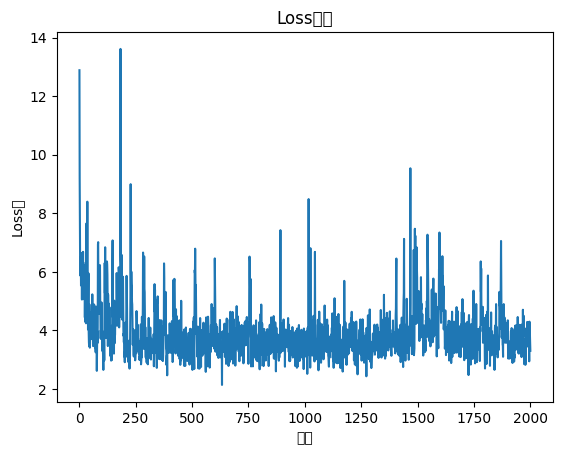

FileNotFoundError: [Errno 2] No such file or directory: './result/Agent_Loss.png'

<Figure size 640x480 with 0 Axes>

In [35]:
# =============== 训练预设 =================================
import matplotlib.pyplot as plt
import time as tm

# =============== 环境设置 =================================
device = torch.device("cuda")
print(f"使用设备{device}进行训练")

env = DiagnoseEnv(dataloader)  # 环境建立
env.togpu(device)  # 迁移到GPU
n_states = env.observation_space()[0]  # 观测空间
n_actions = env.action_space()  # 动作空间

max_episodes = 2000  # 设置训练轮数
max_steps = 80  # 设置最大步数

complete_episodes = 0  # 完成的代数
finished_flag = False  # 结束标志
stop_flag = 1

# =============== 模型设置 =================================

agent = Agent(n_states, n_actions, eta, gamma, capacity, batch_size)  # 建立智能体
agent.togpu(device)  # 迁移到GPU
loss_e = 0  # 代内loss记录值
correct = 0 # 正确分类记录值
loss_temp = []  # 损失值记录缓存
correct_temp = []  # 准确率记录缓存
losses = []  # 记录损失值
corrects = []  # 记录准确率

# =============== 开始训练 =================================
# 填入记忆
state = env.reset()  # 重置环境
state = state.to(device) # 迁移到GPU
for get_memory in range(batch_size):
    action = agent.choose_action(state, get_memory)  # 按状态和代数选择动作
    action.to(device) # 移动到GPU
    next_state, reward = env.step(action)  # 进行动作转化，拿下一个状态
    next_state.to(device)
    reward.to(device)
    agent.memorize(state, action, next_state, reward)  # 记忆回放
print("回放缓存已满，开始训练")

for episode in range(max_episodes):  # 训练轮数
    epi_start = tm.time()  # 本轮开始时间
    state = env.reset()  # 重置环境
    
    for step in range(max_steps):
        
        if episode <= 500:
            episode_in = episode
        else:
            episode_in = episode / (episode // max_steps)
        action = agent.choose_action(state, episode_in)  # 按状态和代数选择动作
        action.to(device)
        next_state, reward = env.step(action)  # 进行动作转化，拿下一个状态
        next_state.to(device)
        reward.to(device)
        temp_reward = reward
            
        agent.memorize(state, action, next_state, reward)  # 记忆回放
        loss_e = agent.update_q_function()  # 更新Q值
        state = next_state  # 进入下个状态
        loss_temp.append(loss_e)  # Loss值填入缓存
        correct = (batch_size + reward) / 2
        correct_temp.append(correct / batch_size * 100)  # 准确率填入缓存
        
    epi_end = tm.time()  # 本轮结束时间
    print(f"训练代数：{episode+1}/{max_episodes}，用时{(epi_end-epi_start):.1f}s，本轮分类准确率{sum(correct_temp) / len(correct_temp):.1f}%，本轮Loss值：{sum(loss_temp) / len(loss_temp)}")
    losses.append(sum(loss_temp) / len(loss_temp))  # 记录代内loss值
    corrects.append(sum(correct_temp) / len(correct_temp))
    loss_temp = []  # 清空缓存
    correct_temp = []  # 清空缓存
    
    
plt.figure()
plt.rcParams['font.sans-serif'] = ['SongTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
epis = [i + 1 for i in range(len(losses))]
plt.plot(epis, losses)
plt.title("Loss曲线")
plt.xlabel("代数")
plt.ylabel("Loss值")
plt.show()
plt.savefig("./result/Agent_Loss.png")


# 模型改进方案

1.对比使用预训练权重和不使用预训练权重的区别

2.利用reward值来判断分类正确的次数。具体做法：设置temp值，获取当前reward，到下一次训练时再获取一次reward，判断if reward > gamma * temp


In [ ]:
loglosses = [np.log10(loss) for loss in losses]
plt.figure()
plt.plot(epis, loglosses)